# Scikit-Learn
[drawdata](https://drawdata.xyz/) is a great site to generate datasets that you can draw yourself

_________________________
## *Prep*
_________________________

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [3]:
df = pd.read_csv('https://calmcode.io/datasets/drawndata1.csv')

In [4]:
df.head(3)

,x,y,z
0,58.080365,225.699042,a
1,238.867357,247.456645,a
2,156.218212,286.588782,a


In [7]:
X =df[['x', 'y']].values
y = df['z'] == "a"

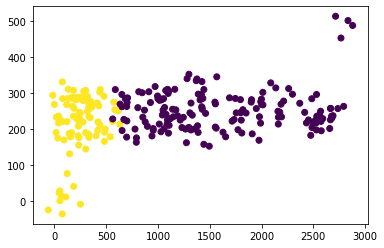

In [9]:
plt.scatter(X[:, 0], X[:, 1], c = y)

### Scaling

- Axes are different scales; scaling will fix this
- SKLearn has a standard scaler
    - calculate the mean and variance of each column
    - x - mean(x) / square root(variance)

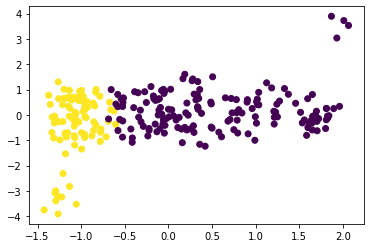

In [10]:
from sklearn.preprocessing import StandardScaler
X_new = StandardScaler().fit_transform(X)
plt.scatter(X_new[:, 0], X_new[:, 1], c = y)

- y is about 8 units
- x is about 3 1/2 units
- outliers are not corrected

### Quantile

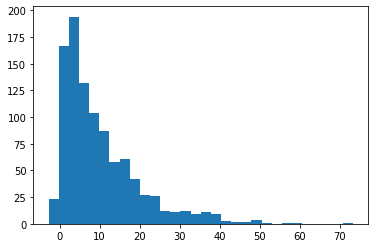

In [13]:
x = np.random.exponential(10, (1000)) + np.random.normal(0, 1, (1000))
plt.hist(x, 30);

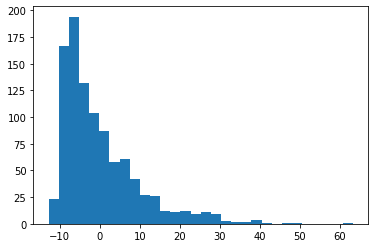

In [14]:
# subtract the mean of the dataset
plt.hist((x - np.mean(x)), 30);

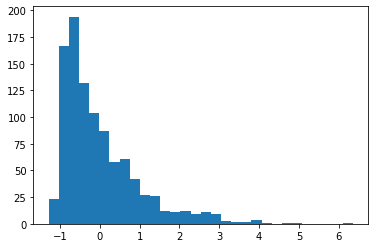

In [15]:
# divide by the standard deviation
plt.hist((x - np.mean(x))/np.std(x), 30);

- x axis is definitely scaled
- but, we still have outliers
- let's come up with a different way to standardize
- fit all `quantiles` (50% of all data to the right of this section, 25% of all data to the right of this section, etc.) evenly across the x axis

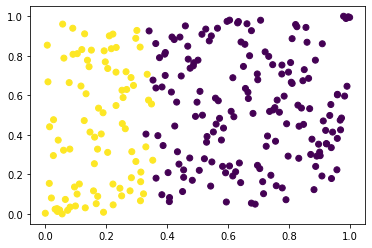

In [18]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
X_new = QuantileTransformer(n_quantiles=100).fit_transform(X)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y);

- quantiles have been used to scale the above, instead of the mean and standard deviation

### Poly

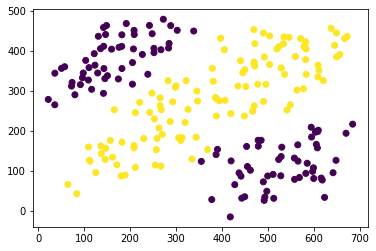

In [20]:
df = pd.read_csv('https://calmcode.io/datasets/drawndata2.csv')
X = df[['x', 'y']].values
y = df['z'] == 'a' 
plt.scatter(X[:, 0], X[:, 1], c=y);

- This data is not very linear, since there is no clear single dividing line between purple and yellow
- Logistic regression may not be the right choice

- Adding a pipeline with a quantiletransform preprosser and then a logistic regression as the model

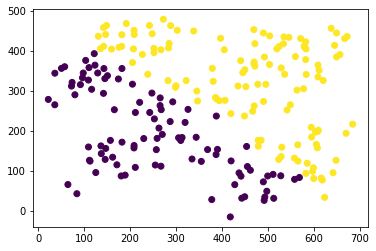

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scale", QuantileTransformer(n_quantiles=100)),
    ("model", LogisticRegression())
])

pred = pipe.fit(X, y).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred);

- This is a bad classifier as well

- the model can currently only take the two axes as the dividing line
- we can limit ourselves to the linear features, but we can also add non-linear features

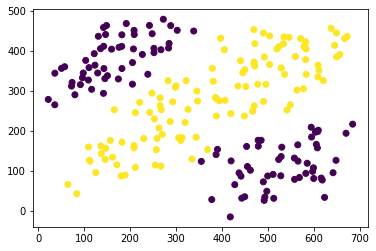

In [26]:
from sklearn.preprocessing import PolynomialFeatures
pipe_poly = Pipeline([
    ("scale", PolynomialFeatures()),
    ("model", LogisticRegression())
])
pred_poly = pipe_poly.fit(X, y).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred_poly);

### OneHot

- preprocessing text data to transform it into numerical data
- OneHotEncoder takes in text and outputs numbers 

In [28]:
arr = np.array(["low", "low", "high", "medium"]).reshape(-1, 1)
arr

array([['low'],
       ['low'],
       ['high'],
       ['medium']], dtype='<U6')

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
enc = OneHotEncoder(sparse=False)
enc.fit_transform(arr)

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [33]:
enc.transform([["zero"]])

ValueError: Found unknown categories ['zero'] in column 0 during transform

- not allowed to pass data that has not been seen before
- can change the handle_unknown from `error` to `ignore`
- updating that gives a 0 array back since `zero` is not in the original data
- this is only good for generating X data, but not for y since that's something you want strict control over

In [35]:
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc.fit_transform(arr)
enc.transform([["zero"]])

array([[0., 0., 0.]])

_________________________
## *Metrics*
_________________________

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

df = pd.read_csv('./datasets/kaggle/creditcard.csv')[:80_000]
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


- has a lot of columns, mostly anonymized
- class and amount at the end, class is what we'd like to predict
- all the V columns are the features of credit card transactions

In [42]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f'{X.shape=}, {y.shape=}, Fraud cases are {y.sum()}'

'X.shape=(80000, 28), y.shape=(80000,), Fraud cases are 196'

### Imbalance
- ~200 out of 80,000 cases are fraudulent
- this dataset is imbalanced

In [44]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression()
mod.fit(X, y).predict(X).sum()

151

- if we're overfitting on just the trained set, the model predicts fewer cases than we actually have (151 vs 196)

In [51]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000)
mod.fit(X, y).predict(X).sum()

171

- adding the `class_weight` dictinary allows us to specify how much weight to apply to each class
    - {0: 1, 1: 2} says for the class 0 assign weight 1 and for class 1 (fraud) we double the weight

### Score

In [53]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={
        'class_weight': 
        [{0: 1, 1: v} for v in range(1, 4)]
    },
    cv=4,
    n_jobs=-1
)

In [54]:
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [56]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,...,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.580209,0.304231,0.007830,0.003539,...,0.99780,0.997413,0.002030,1
1,2.442312,0.387453,0.011138,0.008552,...,0.99805,0.996575,0.003697,2
2,2.600405,0.251568,0.006645,0.002595,...,0.99815,0.995875,0.004980,3


- This shows us the class weight, but also shows all the scores

### Metrics

In [60]:
from sklearn.metrics import precision_score, recall_score

precision = round(precision_score(y, grid.predict(X)), 2)
recall = round(recall_score(y, grid.predict(X)), 2)

print(f'{precision=} and {recall=}')

precision=0.77 and recall=0.59


- recall asks 'did I get all the fraud cases?'
- precision asks 'given that I predict fraud, how accurate am I?'

*extreme examples*
- let's predict every case is a fraud case
    - recall will be very high, precision will be very low

- find one candidate that's a candidate but no one else gets predicted
    - precision will be very high, recall will be very low
### do we care more about false positives or false negatives?
     

### Refit